# Import

In [1]:
import numpy as np
import pandas as pd
import json
import champ_dataset
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import tensorflow_datasets as tfds
import tensorflow as tf
from datasets import load_dataset
from tensorflow.python.client import device_lib
import re
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

2024-09-21 16:48:24.753172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 16:48:24.770381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 16:48:24.790267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 16:48:24.796365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 16:48:24.811663: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-09-21 16:48:45.620488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-21 16:48:45.622672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-21 16:48:45.624575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:2 with 22261 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-09-21 16:48:45.626015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:3 with 22261 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-09-21 16:48:45.627433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5676800130112294417
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23342743552
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 1703118178308102437
 physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capabil

In [4]:
MODEL_NAME = 'distiled_bert'
RUN = 'run3'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/Data/MATH/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN + '/'
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Duong_LLM/Data/MATH/
/nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run3/


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data hendrycks

In [6]:
# Algebra: 16 topics
# Polynomials, Sequences, and Calculus: 13 topics
# Number Theory: 13 topics
# Geometry: 1 topic
# Measurement: 6 topics
# Probability and Combinatorics: 4 topics
# Comparison and Reasoning: 9 topics
TOPIC = ['algebra,polynomial_sequences_calculus,number_theory,geometry,measurement,probability_combinatorics,comparison_reasoning']

In [7]:
data_dict = {
    'number_theory': [],
    'intermediate_algebra': [],
    'algebra': [],
    'geometry': [],
    'precalculus': [],
    'counting_and_probability': [],
    'prealgebra': []
}


for root, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        if filename.endswith('.json'):
            file_path = os.path.join(root, filename)
            subfolder_name = os.path.basename(root)
            if subfolder_name in data_dict:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    
                    data_dict[subfolder_name].append(data['problem'])

In [8]:


rename_mapping = {
    'intermediate_algebra': 'algebra',
    'precalculus': 'polynomial_sequences_calculus',
    'counting_and_probability': 'probability_combinatorics',
    'prealgebra': 'algebra'
}


def remove_formatting(text):
    # Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    # Remove curly braces
    text = re.sub(r'{|}', '', text)
    # Remove Markdown formatting (e.g., **bold**, *italic*, `code`)
    text = re.sub(r'\*\*|\*|`', '', text)
    # Remove Markdown headers (e.g., # Header)
    text = re.sub(r'#', '', text)
    # Remove escape characters
    text = re.sub(r'\\', '', text)
    # remove special character
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\$', '', text)
    # Remove everything after '(A)'
    text = re.sub(r'\(A\).*', '', text)
    text = re.sub(r'\(a\).*', '', text)
    # Remove everything after "b'"
    text = re.sub(r'b\'', '', text)
    return text



In [9]:
df_all = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))
df_all = df_all.melt(var_name='topic',value_name='problem')
df_all = df_all.dropna().reset_index(drop=True)
df_all['problem'] = df_all['problem'].apply(remove_formatting)
df_all['topic'] = df_all['topic'].replace(rename_mapping)
df_all

,topic,problem
0,number_theory,What is the smallest prime divisor of 5^23 + 7...
1,number_theory,What is the largest positive integer with only...
2,number_theory,What is the greatest prime factor of 12! + 14!...
3,number_theory,What is the largest four-digit negative intege...
4,number_theory,How many positive divisors of 150 are not divi...
...,...,...
12501,algebra,Four students agreed to pool their savings to ...
12502,algebra,What is the perimeter of trapezoid ABCD? [asy]...
12503,algebra,Three identical squares are placed side by sid...
12504,algebra,If the square root of the length of the hypote...


In [10]:
df_all.groupby('topic').size()

topic
algebra                          7205
geometry                         1355
number_theory                    1409
polynomial_sequences_calculus    1292
probability_combinatorics        1245
dtype: int64

# Load data deepmind

In [11]:
topic = ['algebra__linear_1d', 'algebra__linear_1d_composed', 'algebra__linear_2d', 'algebra__linear_2d_composed', \
         'algebra__polynomial_roots', 'algebra__polynomial_roots_composed', \
         'algebra__sequence_next_term', 'algebra__sequence_nth_term', \
         'arithmetic__add_or_sub', 'arithmetic__add_or_sub_in_base', 'arithmetic__add_sub_multiple', 'arithmetic__div', \
         'arithmetic__mixed', 'arithmetic__mul', 'arithmetic__mul_div_multiple', 'arithmetic__nearest_integer_root', 'arithmetic__simplify_surd', \
         'calculus__differentiate', 'calculus__differentiate_composed', \
         'comparison__closest', 'comparison__closest_composed', 'comparison__kth_biggest', 'comparison__kth_biggest_composed', \
         'comparison__pair', 'comparison__pair_composed', 'comparison__sort', 'comparison__sort_composed', \
         'measurement__conversion', 'measurement__time', \
         'numbers__base_conversion', 'numbers__div_remainder', 'numbers__div_remainder_composed', 'numbers__gcd', 'numbers__gcd_composed',\
         'numbers__is_factor', 'numbers__is_factor_composed', 'numbers__is_prime', 'numbers__is_prime_composed', 'numbers__lcm', \
         'numbers__lcm_composed', 'numbers__list_prime_factors', 'numbers__list_prime_factors_composed', 'numbers__place_value', \
         'numbers__place_value_composed', 'numbers__round_number', 'numbers__round_number_composed',\
         'polynomials__add', 'polynomials__coefficient_named', 'polynomials__collect', 'polynomials__compose', 'polynomials__evaluate',\
         'polynomials__evaluate_composed', 'polynomials__expand', 'polynomials__simplify_power', 'probability__swr_p_level_set',\
         'probability__swr_p_sequence']

In [12]:
from datasets import load_dataset
train = load_dataset("deepmind/math_dataset", 'polynomials__compose',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_data = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_data['problem'] = train['question'][begin:end]
df_data['topic'] = 'polynomial_sequences_calculus'

In [13]:
train = load_dataset("deepmind/math_dataset", 'polynomials__evaluate_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 500 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'polynomial_sequences_calculus'

#concat
df_data = pd.concat([df_data,df_temp])

In [14]:
train = load_dataset("deepmind/math_dataset", 'calculus__differentiate_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 500 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'polynomial_sequences_calculus'

#concat
df_data = pd.concat([df_data,df_temp])

In [15]:
df_data

,problem,topic
0,b'Let i(g) = -153*g**2. Let u(f) = -f**2 + 12*...,polynomial_sequences_calculus
1,b'Let n(m) = 9*m**2 + 5. Let i(p) be the first...,polynomial_sequences_calculus
2,b'Let c(b) = 2*b. Suppose 0 = 2*h - 0*h. Let g...,polynomial_sequences_calculus
3,b'Let z(g) = -2*g. Let s(d) = 73*d**2 + 68 + 7...,polynomial_sequences_calculus
4,b'Let n(o) = -o. Let v(a) = 7*a + 22. Let s(d)...,polynomial_sequences_calculus
...,...,...
495,b'Let b(d) be the first derivative of 9*d**7/7...,polynomial_sequences_calculus
496,b'Let r(s) = -s + 3*s**2 + s**2 - 4*s**2 - s**...,polynomial_sequences_calculus
497,b'Let t(p) be the third derivative of p**6/24 ...,polynomial_sequences_calculus
498,b'What is the first derivative of -61*p**3 + 1...,polynomial_sequences_calculus


In [16]:
train = load_dataset("deepmind/math_dataset", 'numbers__div_remainder_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])


In [17]:
train = load_dataset("deepmind/math_dataset", 'numbers__gcd_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [18]:
train = load_dataset("deepmind/math_dataset", 'numbers__is_factor_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [19]:
train = load_dataset("deepmind/math_dataset", 'numbers__is_prime_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [20]:
train = load_dataset("deepmind/math_dataset", 'numbers__lcm_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [21]:
train = load_dataset("deepmind/math_dataset", 'numbers__list_prime_factors_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [22]:
train = load_dataset("deepmind/math_dataset", 'numbers__place_value_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 200 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [23]:
train = load_dataset("deepmind/math_dataset", 'numbers__round_number_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 100 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'number_theory'

#concat
df_data = pd.concat([df_data,df_temp])

In [24]:
df_data

,problem,topic
0,b'Let i(g) = -153*g**2. Let u(f) = -f**2 + 12*...,polynomial_sequences_calculus
1,b'Let n(m) = 9*m**2 + 5. Let i(p) be the first...,polynomial_sequences_calculus
2,b'Let c(b) = 2*b. Suppose 0 = 2*h - 0*h. Let g...,polynomial_sequences_calculus
3,b'Let z(g) = -2*g. Let s(d) = 73*d**2 + 68 + 7...,polynomial_sequences_calculus
4,b'Let n(o) = -o. Let v(a) = 7*a + 22. Let s(d)...,polynomial_sequences_calculus
...,...,...
95,b'Let b = 1212 - 1211.91173. Round b to 3 deci...,number_theory
96,b'Let u = -3.381 - -185.481. Round u to the ne...,number_theory
97,b'Let l = -2.9889629 - 1329.5983371. Let s = 1...,number_theory
98,b'Let t = 21324.9989507 + -21325. What is t ro...,number_theory


In [25]:
train = load_dataset("deepmind/math_dataset", 'measurement__conversion',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'measurement'

#concat
df_data = pd.concat([df_data,df_temp])

In [26]:
train = load_dataset("deepmind/math_dataset", 'measurement__time',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'measurement'

#concat
df_data = pd.concat([df_data,df_temp])

In [27]:
df_data

,problem,topic
0,b'Let i(g) = -153*g**2. Let u(f) = -f**2 + 12*...,polynomial_sequences_calculus
1,b'Let n(m) = 9*m**2 + 5. Let i(p) be the first...,polynomial_sequences_calculus
2,b'Let c(b) = 2*b. Suppose 0 = 2*h - 0*h. Let g...,polynomial_sequences_calculus
3,b'Let z(g) = -2*g. Let s(d) = 73*d**2 + 68 + 7...,polynomial_sequences_calculus
4,b'Let n(o) = -o. Let v(a) = 7*a + 22. Let s(d)...,polynomial_sequences_calculus
...,...,...
595,b'What is 303 minutes after 1:29 AM?\n',measurement
596,b'What is 470 minutes before 4:34 AM?\n',measurement
597,b'How many minutes are there between 3:14 AM a...,measurement
598,b'What is 467 minutes after 5:48 PM?\n',measurement


In [28]:
train = load_dataset("deepmind/math_dataset", 'probability__swr_p_level_set',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'probability_combinatorics'

#concat
df_data = pd.concat([df_data,df_temp])

In [29]:
train = load_dataset("deepmind/math_dataset", 'probability__swr_p_sequence',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 600 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'probability_combinatorics'

#concat
df_data = pd.concat([df_data,df_temp])

In [30]:
df_data

,problem,topic
0,b'Let i(g) = -153*g**2. Let u(f) = -f**2 + 12*...,polynomial_sequences_calculus
1,b'Let n(m) = 9*m**2 + 5. Let i(p) be the first...,polynomial_sequences_calculus
2,b'Let c(b) = 2*b. Suppose 0 = 2*h - 0*h. Let g...,polynomial_sequences_calculus
3,b'Let z(g) = -2*g. Let s(d) = 73*d**2 + 68 + 7...,polynomial_sequences_calculus
4,b'Let n(o) = -o. Let v(a) = 7*a + 22. Let s(d)...,polynomial_sequences_calculus
...,...,...
595,b'Two letters picked without replacement from ...,probability_combinatorics
596,b'What is prob of sequence ccgc when four lett...,probability_combinatorics
597,b'What is prob of sequence geg when three lett...,probability_combinatorics
598,b'Three letters picked without replacement fro...,probability_combinatorics


In [31]:
train = load_dataset("deepmind/math_dataset", 'comparison__closest_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [32]:
train = load_dataset("deepmind/math_dataset", 'comparison__kth_biggest_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 300 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [33]:
train = load_dataset("deepmind/math_dataset", 'comparison__pair_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 900 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [34]:
train = load_dataset("deepmind/math_dataset", 'comparison__sort_composed',  split='train', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", trust_remote_code=True)
df_temp = pd.DataFrame()
begin = 10000
end = begin + 900 # only take limit problem
df_temp['problem'] = train['question'][begin:end]
df_temp['topic'] = 'comparison_reasoning'

#concat
df_data = pd.concat([df_data,df_temp])

In [35]:
df_data

,problem,topic
0,b'Let i(g) = -153*g**2. Let u(f) = -f**2 + 12*...,polynomial_sequences_calculus
1,b'Let n(m) = 9*m**2 + 5. Let i(p) be the first...,polynomial_sequences_calculus
2,b'Let c(b) = 2*b. Suppose 0 = 2*h - 0*h. Let g...,polynomial_sequences_calculus
3,b'Let z(g) = -2*g. Let s(d) = 73*d**2 + 68 + 7...,polynomial_sequences_calculus
4,b'Let n(o) = -o. Let v(a) = 7*a + 22. Let s(d)...,polynomial_sequences_calculus
...,...,...
895,b'Let z = -25 - -25. Let m(i) = i**3 + 5*i**2 ...,comparison_reasoning
896,b'Let j(a) be the third derivative of a**5/60 ...,comparison_reasoning
897,b'Let g = -0.9 + 20.3. Let b = 19 - g. Put 0.1...,comparison_reasoning
898,"b'Let b = 747 + -745. Sort b, -1/113, 2/3 in a...",comparison_reasoning


# Finalizing and spliting data

In [36]:
df_data['problem'] = df_data['problem'].apply(remove_formatting)
df_data

,problem,topic
0,Let i(g) = -153g2. Let u(f) = -f2 + 12f - 6. C...,polynomial_sequences_calculus
1,Let n(m) = 9m2 + 5. Let i(p) be the first deri...,polynomial_sequences_calculus
2,Let c(b) = 2b. Suppose 0 = 2h - 0h. Let g(n) =...,polynomial_sequences_calculus
3,Let z(g) = -2g. Let s(d) = 73d2 + 68 + 72 - 14...,polynomial_sequences_calculus
4,Let n(o) = -o. Let v,polynomial_sequences_calculus
...,...,...
895,Let z = -25 - -25. Let m(i) = i3 + 5i2 + 3i + ...,comparison_reasoning
896,Let j,comparison_reasoning
897,"Let g = -0.9 + 20.3. Let b = 19 - g. Put 0.1, ...",comparison_reasoning
898,"Let b = 747 + -745. Sort b, -1/113, 2/3 in asc...",comparison_reasoning


In [37]:
df_all = pd.concat([df_all,df_data]).reset_index(drop = True)
df_all

,topic,problem
0,number_theory,What is the smallest prime divisor of 5^23 + 7...
1,number_theory,What is the largest positive integer with only...
2,number_theory,What is the greatest prime factor of 12! + 14!...
3,number_theory,What is the largest four-digit negative intege...
4,number_theory,How many positive divisors of 150 are not divi...
...,...,...
19701,comparison_reasoning,Let z = -25 - -25. Let m(i) = i3 + 5i2 + 3i + ...
19702,comparison_reasoning,Let j
19703,comparison_reasoning,"Let g = -0.9 + 20.3. Let b = 19 - g. Put 0.1, ..."
19704,comparison_reasoning,"Let b = 747 + -745. Sort b, -1/113, 2/3 in asc..."


In [38]:
df_all.groupby('topic').size()

topic
algebra                          7205
comparison_reasoning             2400
geometry                         1355
measurement                      1200
number_theory                    2509
polynomial_sequences_calculus    2592
probability_combinatorics        2445
dtype: int64

In [39]:
max_rows_per_topic = 2500

In [40]:
df_limited = df_all.groupby('topic', group_keys=False, as_index=False)[['topic', 'problem']].apply(
    lambda x: x.sample(min(len(x), max_rows_per_topic // 2 if x.name == 'algebra' else max_rows_per_topic), random_state=96))
df_limited = df_limited.reset_index(drop=True)
df_limited

,topic,problem
0,algebra,The function f(x) satisfies[f(f(x)) = 6x - 200...
1,algebra,What is the minimum value of the expression x^...
2,algebra,Let a and b be nonzero real constants such tha...
3,algebra,"Find the ordered pair (a,b) of real numbers su..."
4,algebra,"If f(x) = x^3 - 6x^2 + 3x - 4, g(x) = x^3 + 5x..."
...,...,...
13645,probability_combinatorics,Four letters picked without replacement from y...
13646,probability_combinatorics,Two letters picked without replacement from h:...
13647,probability_combinatorics,What is prob of picking 2 t when two letters p...
13648,probability_combinatorics,Find the constant term in the expansion of (10...


In [41]:
topic_mapping = {
    'algebra': 0,
    'polynomial_sequences_calculus': 1,
    'number_theory': 2,
    'geometry': 3,
    'measurement': 4,
    'probability_combinatorics': 5,
    'comparison_reasoning': 6
}

# Apply the mapping to the 'topic' column
df_limited['topic_encoded'] = df_limited['topic'].replace(topic_mapping)

/tmp/ipykernel_159274/1894251133.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_limited['topic_encoded'] = df_limited['topic'].replace(topic_mapping)


In [42]:
df_limited.groupby('topic').size()

topic
algebra                          1250
comparison_reasoning             2400
geometry                         1355
measurement                      1200
number_theory                    2500
polynomial_sequences_calculus    2500
probability_combinatorics        2445
dtype: int64

In [43]:
df_limited.groupby('topic_encoded').size()

topic_encoded
0    1250
1    2500
2    2500
3    1355
4    1200
5    2445
6    2400
dtype: int64

In [44]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

X = list(df_limited['problem'])
Y = list(df_limited['topic_encoded'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [46]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))


10920
10920
2730
2730


In [47]:
#load tokenizer
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/")
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

/home/qdang1/.conda/envs/tf2/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
list(y_train)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
dict(test_encodings),
list(y_test)
))

2024-09-21 16:49:41.687099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22261 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-09-21 16:49:41.687563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22261 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-09-21 16:49:41.688023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22261 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-09-21 16:49:41.688460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22261 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, comp

# Training

In [49]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=7, cache_dir="/nfs/ada/jbrook1/users/qdang1/temp/", dropout = 0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
config = model.config
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.5,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}

In [51]:
PATIENCE = 8
EPOCH = 200
BATCH_SIZE = 32

In [52]:

reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE,verbose=1, min_delta=0.0001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True)

model.fit(train_dataset.shuffle(1000).batch(BATCH_SIZE),epochs=EPOCH,batch_size=BATCH_SIZE,validation_data=test_dataset.shuffle(1000).batch(BATCH_SIZE),
          callbacks=[reduce_LR_On_Plateau,early_stopping])

Epoch 1/200


I0000 00:00:1726951813.288037  159651 service.cc:146] XLA service 0x2aafb8246710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726951813.288072  159651 service.cc:154]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1726951813.288077  159651 service.cc:154]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1726951813.288080  159651 service.cc:154]   StreamExecutor device (2): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1726951813.288082  159651 service.cc:154]   StreamExecutor device (3): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1726951813.288085  159651 service.cc:154]   StreamExecutor device (4): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1726951813.288087  159651 service.cc:154]   StreamExecutor device (5): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1726951813.288090  159651 service.cc:154]   StreamExecutor device (6): Quadro RTX

342/342 [==============================] - 269s 689ms/step - loss: 0.6262 - accuracy: 0.7848 - val_loss: 0.3075 - val_accuracy: 0.8967 - lr: 5.0000e-05
Epoch 2/200
342/342 [==============================] - 234s 686ms/step - loss: 0.2897 - accuracy: 0.8979 - val_loss: 0.2918 - val_accuracy: 0.8996 - lr: 5.0000e-05
Epoch 3/200
342/342 [==============================] - 234s 686ms/step - loss: 0.2291 - accuracy: 0.9187 - val_loss: 0.2679 - val_accuracy: 0.9059 - lr: 5.0000e-05
Epoch 4/200
342/342 [==============================] - 234s 683ms/step - loss: 0.1919 - accuracy: 0.9349 - val_loss: 0.2976 - val_accuracy: 0.9066 - lr: 5.0000e-05
Epoch 5/200
342/342 [==============================] - 235s 686ms/step - loss: 0.1703 - accuracy: 0.9411 - val_loss: 0.2674 - val_accuracy: 0.9095 - lr: 5.0000e-05
Epoch 6/200
342/342 [==============================] - 234s 685ms/step - loss: 0.1451 - accuracy: 0.9483 - val_loss: 0.2969 - val_accuracy: 0.9081 - lr: 5.0000e-05
Epoch 7/200
342/342 [=======

In [53]:
model.save_pretrained(OUTPUT_DIR + 'model')

In [54]:
model_loaded = TFDistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR + 'model')

Some layers from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run3/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /nfs/ada/jbrook1/users/qdang1/Duong_LLM/output/run3/model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

In [55]:
output_list = []
for i in range(0,len(X_test),32):
    predict_input = tokenizer(X_test[i:i+32],truncation=True,padding=True,return_tensors="tf")
    output = model_loaded(predict_input)[0]
    output_list.extend(output)

output_list = np.array(output_list)
output_list.shape

(2730, 7)

In [56]:
y_pred = np.argmax(output_list,axis=1)

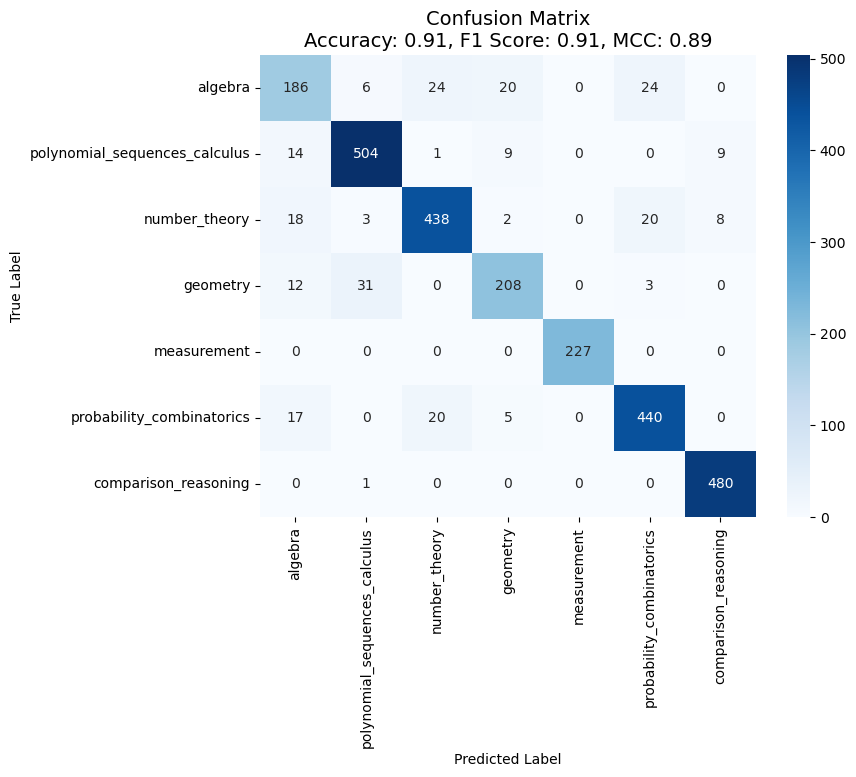

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

# Define the labels for the x and y ticks
tick_labels = ['algebra', 'polynomial_sequences_calculus', 'number_theory', 'geometry', 
               'measurement', 'probability_combinatorics', 'comparison_reasoning']

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy, F1 score, and MCC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
mcc = matthews_corrcoef(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)

# Add accuracy, F1 score, and MCC in the title
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, MCC: {mcc:.2f}', fontsize=14)

# Label axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show plot
plt.savefig(OUTPUT_DIR + "confusion_matrix.png")
plt.show()
